# Handwritten Image Classification with Vision Transformers

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
BATCH_SIZE = 64
LR = 1e-4
NUM_EPOCHES = 10

## Preprocessing

In [4]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

In [5]:
trainset = datasets.MNIST('data/MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('data/MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
from models.transformer import MultiHeadAttention
    
class VisionEncoder(nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size, dropout=0.1):
        super(VisionEncoder, self).__init__()
    
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)
        
        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, dropout=dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.embed_size),
            nn.Dropout(self.dropout)
        )
    
    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x)
        x = x + self.ff(self.norm2(x))
        return x
    
class ViT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=0.1):
        super(ViT, self).__init__()
        
        self.p = patch_size
        self.image_size = image_size
        self.embed_size = embed_size
        self.num_patches = (image_size//patch_size)**2
        self.patch_size = channel_size*patch_size**2
        self.num_heads = num_heads
        self.classes = classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        
        self.embeddings = nn.Linear(self.patch_size, self.embed_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        
        self.encoders = nn.ModuleList([])
        for layer in range(self.num_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.num_heads, self.hidden_size, dropout))
        
        self.norm = nn.LayerNorm(self.embed_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_size, self.classes)
        )
        
    def forward(self, x):
        b, c, h, w = x.size()        
        
        x = x.reshape(b, int((h/self.p)*(w/self.p)), c*self.p*self.p)
        x = self.embeddings(x)

        b, n, e = x.size()
        class_tokens = self.class_token.expand(b, 1, e)
        
        x = torch.cat((x, class_tokens), dim=1)
        
        for encoder in self.encoders:
            x = encoder(x)
        
        x = x[:, 0, :]
        
        x = F.log_softmax(self.classifier(self.norm(x)), dim=-1)
        
        return x

In [7]:
image_size = 28
channel_size = 1
patch_size = 7
embed_size = 512
num_heads = 8
classes = 10
num_layers = 2
hidden_size = 256
dropout = 0.1

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout): Dropout(p=0.1, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0): VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.1, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=512, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): VisionEncoder(
 

In [8]:
for img, label in trainloader:
    img = img.to(device)
    label = label.to(device)
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    
    print("Output Dimensions: {}".format(out.size()))
    break

Input Image Dimensions: torch.Size([64, 1, 28, 28])
Label Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])


In [9]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [10]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(0, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
    

-------------------------------------------------
Epoch: 0 Train mean loss: 706.18383941
       Train Accuracy:  0.7541833333333333 == 45251 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 1 Train mean loss: 387.27960946
       Train Accuracy:  0.8680166666666667 == 52081 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 307.15070452
       Train Accuracy:  0.89445 == 53667 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 254.54039502
       Train Accuracy:  0.9126166666666666 == 54757 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 217.74423554
       Train Accuracy:  0.92465 == 55479 / 60000
-------------------------------------------------
---------------------------

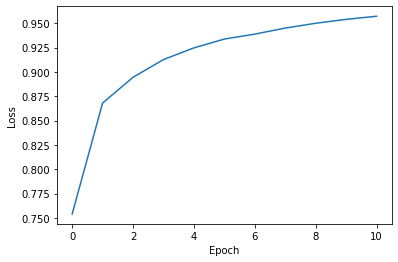

In [11]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

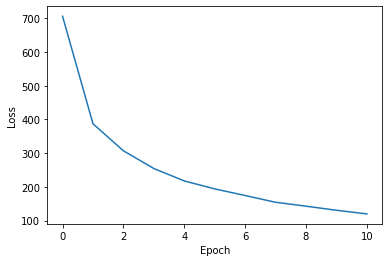

In [12]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [13]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
    
        preds = model(img)
    
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
    
    print("Test Accuracy: ", len([True for x, y in zip(y_pred_test, y_true_test) if x==y])/len(y_pred_test), "==", len([True for x, y in zip(y_pred_test, y_true_test) if x==y]), "/", len(y_pred_test))

Test Accuracy:  0.0532 == 532 / 10000
